# BreaQ QML Track: Hybrid Quantum-Classical Neural Networks for RetinaMNIST

This hackathon focuses on developing hybrid quantum–classical neural networks for the RetinaMNIST dataset. *The emphasis is on designing interesting hybrid models and on finding meaningful metrics to investigate the advantage of using quantum resources.* You are encouraged to experiment with architecture design, analyze performance, and propose meaningful experiments or metrics that quantify the impact of quantum resources within the model.

To support this process, the notebook presents a complete, ready-to-run pipeline based on PyTorch and PennyLane. The example demonstrates data handling, model construction, training, and evaluation using a hybrid neural network workflow. 

#### Feel free to reuse or adapt the provided implementation in any form. The only mandatory requirements for submissions are the use of PennyLane and PyTorch.

In [16]:
import json
import numpy as np
from PIL import Image
from medmnist import RetinaMNIST
import pennylane as qml
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from typing import Tuple


## The Dataset: RetinaMNIST

RetinaMNIST is a compact medical imaging dataset composed of retinal fundus photographs labeled on a 5-point diabetic retinopathy severity scale. Although the task is inherently ordinal regression, it is often treated as a standard multi-class classification problem. Its limited size and low resolution make it well suited for rapid experimentation, benchmarking lightweight models, and evaluating hybrid quantum–classical approaches under realistic small-data constraints.

In the following, you are provided with a class to help you load and preprocess the RetinaMNIST dataset. The class handles downloading the data, applying necessary transformations, and preparing it for training and evaluation. Some of the methods already implemented:
 - `__init__`: Loads train, validation, and test splits into memory and formats images and labels.
 - `select_classes`: Filters all splits to keep only a specified set of class IDs.
 - `select_train_percentage`: Retains only a chosen fraction of the training set, with optional shuffling.
 - `normalize`: Applies either min–max scaling or standardization independently to each split.
 - `to_grayscale`: Converts all images to single-channel grayscale format.
 - `resize`: Resizes images in every split to a specified spatial resolution.

Bellow the `DataHandler` implementations there are also some usage examples.

In [17]:
class DataHandler:
    def __init__(self, download=True, as_rgb=True):
        """
        Loads train/val/test splits simultaneously.
        """
        self.datasets = {}
        self.images = {}
        self.labels = {}

        for split in ["train", "val", "test"]:
            ds = RetinaMNIST(split=split, download=download)
            imgs = ds.imgs  # (N, 28, 28)
            labels = ds.labels.squeeze()

            if imgs.ndim == 3:
                if as_rgb:
                    imgs = np.stack([imgs]*3, axis=-1)   # (N, H, W, 3)
                else:
                    imgs = imgs[..., None]               # (N, H, W, 1)

            self.images[split] = imgs.astype(np.uint8)
            self.labels[split] = labels.astype(int)

        self.active_classes = {
            split: np.unique(self.labels[split]) for split in ["train", "val", "test"]
        }

    def select_classes(self, classes):
        """
        Keep only specific class IDs across train, val, test.
        """
        for split in ["train", "val", "test"]:
            cls_set = set(classes)
            mask = np.array([lbl in cls_set for lbl in self.labels[split]])
            self.images[split] = self.images[split][mask]
            self.labels[split] = self.labels[split][mask]
            self.active_classes[split] = np.array(sorted(classes))

    def select_train_percentage(self, pct, shuffle=True, seed=None):
        """
        Keep only a percentage of the training data, preserving class proportions.
        pct: float in (0,1]
        """
        assert 0 < pct <= 1
        N = len(self.labels["train"])
        n_keep = int(N * pct)

        rng = np.random.default_rng(seed)

        classes, counts = np.unique(self.labels["train"], return_counts=True)
        # desired (float) and initial integer allocation per class
        desired = counts * pct
        per_class = np.floor(desired).astype(int)

        # adjust to match total n_keep by distributing the remaining slots
        remainder = n_keep - per_class.sum()
        if remainder > 0:
            fracs = desired - per_class
            order = np.argsort(-fracs)  # largest fractional parts first
            for i in order[:remainder]:
                per_class[i] += 1
        elif remainder < 0:
            rem = -remainder
            fracs = desired - per_class
            order = np.argsort(fracs)  # smallest fractional parts first
            for i in order:
                if per_class[i] > 0:
                    per_class[i] -= 1
                    rem -= 1
                    if rem == 0:
                        break

        # gather indices per class
        keep_idx_list = []
        for cls, k in zip(classes, per_class):
            cls_idx = np.where(self.labels["train"] == cls)[0].copy()
            if shuffle:
                rng.shuffle(cls_idx)
            if k > 0:
                keep_idx_list.append(cls_idx[:k])

        if keep_idx_list:
            keep_idx = np.concatenate(keep_idx_list)
        else:
            keep_idx = np.array([], dtype=int)

        if shuffle and keep_idx.size:
            rng.shuffle(keep_idx)

        self.images["train"] = self.images["train"][keep_idx]
        self.labels["train"] = self.labels["train"][keep_idx]
        self.active_classes["train"] = np.unique(self.labels["train"])

    def normalize(self, method="minmax"):
        """
        Normalize each split independently.
        """
        for split in ["train", "val", "test"]:
            imgs = self.images[split].astype(np.float32)

            if method == "minmax":
                min_val = imgs.min(axis=(0,1,2), keepdims=True)
                max_val = imgs.max(axis=(0,1,2), keepdims=True)
                imgs = (imgs - min_val) / (max_val - min_val + 1e-7)

            elif method == "standard":
                mean = imgs.mean(axis=(0,1,2), keepdims=True)
                std = imgs.std(axis=(0,1,2), keepdims=True) + 1e-7
                imgs = (imgs - mean) / std

            else:
                raise ValueError("Unknown normalization method.")

            self.images[split] = imgs

    def to_grayscale(self):
        """
        Convert images in all splits to grayscale.
        """
        for split in ["train", "val", "test"]:
            gray_list = []
            for img in self.images[split]:
                pil = Image.fromarray(img).convert("L")
                gray_list.append(np.array(pil))
            gray_arr = np.stack(gray_list, axis=0)
            self.images[split] = gray_arr[..., None]

    def resize(self, size):
        """
        Resize images in all splits to (width, height).
        """
        for split in ["train", "val", "test"]:
            out = []
            for img in self.images[split]:
                if img.shape[-1] == 1:
                    pil = Image.fromarray(img.squeeze(), mode="L")
                else:
                    pil = Image.fromarray(img)

                pil = pil.resize(size, Image.BILINEAR)
                arr = np.array(pil)

                if arr.ndim == 2:
                    arr = arr[..., None]

                out.append(arr)
            self.images[split] = np.stack(out, axis=0)


# ------------- Dataset wrapper -------------
def build_dataloaders_fast(dh, batch_size=128, device='cuda'):
    """
    Pre-convert all images to torch.Tensor once.
    """
    loaders = {}
    for split in ["train", "val", "test"]:
        imgs = torch.from_numpy(dh.images[split]).float()  # (N,H,W,C)
        # HWC -> CHW
        imgs = imgs.permute(0,3,1,2)
        if imgs.max() > 1.0:
            imgs /= 255.0
        labels = torch.from_numpy(dh.labels[split]).long()
        dataset = TensorDataset(imgs, labels)
        shuffle = (split == "train")
        loaders[split] = DataLoader(dataset, batch_size=batch_size,
                                    shuffle=shuffle,
                                    num_workers=4,  # increase if your CPU has cores
                                    pin_memory=True if device=='cuda' else False)
    return loaders


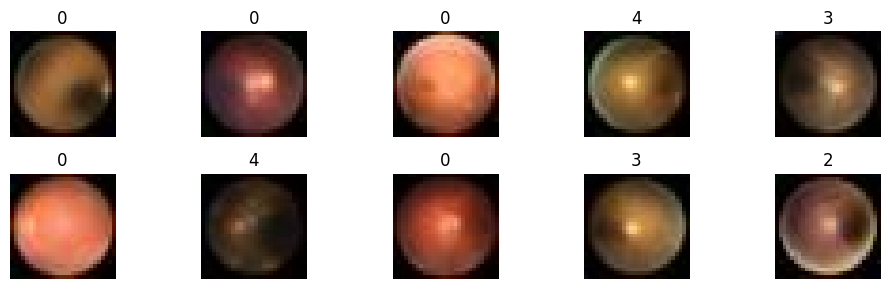

In [18]:
# Raw
import matplotlib.pyplot as plt

dh = DataHandler()

imgs = dh.images["train"][:10]
labels = dh.labels["train"][:10]

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])
    plt.axis("off")
    plt.title(labels[i])
plt.tight_layout()
plt.show()


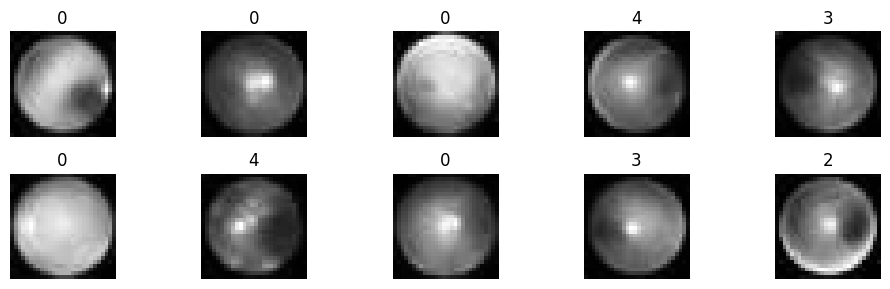

In [19]:
# Grayscale
dh = DataHandler()
dh.to_grayscale()

imgs = dh.images["train"][:10].squeeze(-1)
labels = dh.labels["train"][:10]

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i], cmap="gray")
    plt.axis("off")
    plt.title(labels[i])
plt.tight_layout()
plt.show()

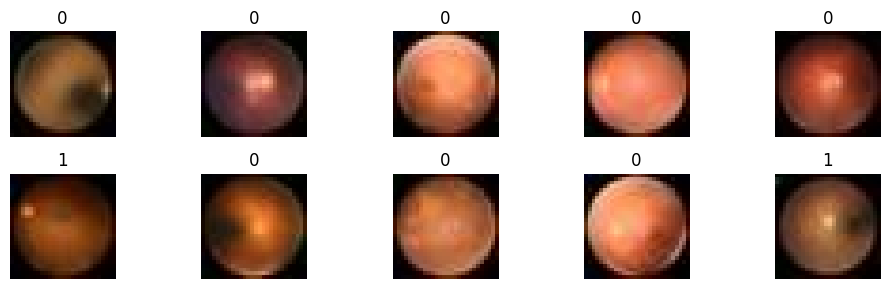

In [20]:
# Classes 0 and 1
dh = DataHandler()
dh.select_classes([0, 1])

imgs = dh.images["train"][:10]
labels = dh.labels["train"][:10]

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])
    plt.axis("off")
    plt.title(labels[i])
plt.tight_layout()
plt.show()

In [21]:
# keep 20% of the training set
dh = DataHandler()

print("Before:", len(dh.labels["train"]))

dh.select_train_percentage(0.2, seed=0)

print("After:", len(dh.labels["train"]))

Before: 1080
After: 216


## The model: building HQNNs with PennyLane and PyTorch

The model combines classical deep learning components from PyTorch with a trainable quantum circuit defined using PennyLane. The outer structure is a subclass of `torch.nn.Module`, which is the standard building block for neural networks in PyTorch. Layers are defined in the constructor and organized into `nn.Sequential` blocks, allowing multiple operations such as convolutions, activations, pooling, and linear layers to be stacked into a forward pipeline.

The quantum part is defined as a function decorated with `@qml.qnode`, which tells PennyLane to turn it into a differentiable quantum computation. The shape of the trainable quantum parameters is declared through `weight_shapes`, which ensures compatibility with downstream optimization. The quantum circuit is wrapped with `qml.qnn.TorchLayer`, allowing it to behave like a standard neural network layer inside PyTorch. This means it receives and outputs tensors just like a classical layer and its parameters are tracked by PyTorch’s optimizer. Both quantum and classical weights participate in the same training loop.

The `forward` method defines the flow of data: images pass first through convolutional feature extraction, then through the classifier, and finally through the quantum layer. Gradients propagate automatically across the entire pipeline. PennyLane provides differentiable quantum simulations, while PyTorch’s autograd engine ensures that parameter updates seamlessly include both the neural network weights and the quantum circuit parameters in a single backward pass.

In [ ]:
def build_model(num_classes: int, in_channels: int = 1):
    n_qubits = num_classes
    dev = qml.device("default.qubit", wires=n_qubits)
    

    n_layers = 3
    
    weight_shapes = {"weights": (n_layers, n_qubits, 3)}

    @qml.qnode(dev)
    def qnode(inputs, weights):

        for i in range(n_layers):
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
            qml.StronglyEntanglingLayers(weights[i].unsqueeze(0), wires=range(n_qubits))
        
        return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

    class HybridCNN(nn.Module):
        def __init__(self, in_ch, n_classes):
            super().__init__()
            

            self.features = nn.Sequential(
                nn.Conv2d(in_ch, 16, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(16), nn.MaxPool2d(2),
                nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
                nn.AdaptiveAvgPool2d(1)
            )
            
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(32, n_qubits),

                nn.Tanh(), 
                qml.qnn.TorchLayer(qnode, weight_shapes)
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    return HybridCNN(in_channels, num_classes)

For prototyping it is useful to visualize the quantum circuits. The following cell shows how to plot a quantum circuit using PennyLane's built-in drawing capabilities. The argument `level=None` ensures that all operations are displayed without collapsing them into higher-level gates.

c:\Users\Tavi\vs_code_projects\roqteam-qml\roqteam-qml\.venv\Lib\site-packages\pennylane\workflow\construct_batch.py:418: PennyLaneDeprecationWarning: Using `level=None` is deprecated and will be removed in a future release. Please use `level='device'` to include all transforms.
  _validate_level(level)


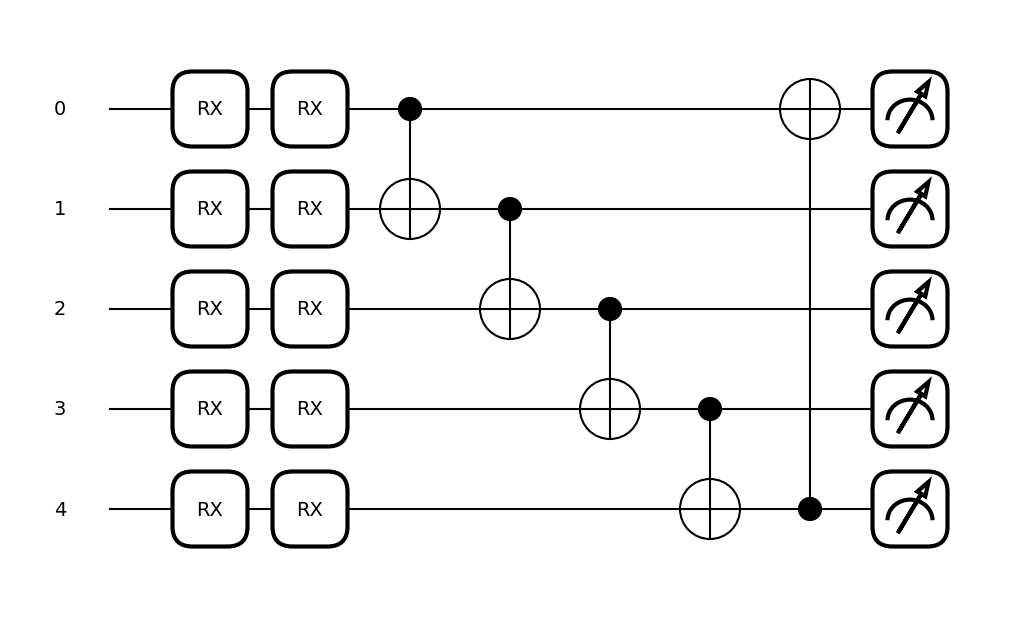

In [126]:
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

fig, ax = qml.draw_mpl(qnode, level=None)(
    np.random.rand(n_qubits), np.random.rand(1, n_qubits)
)
plt.show()

## Training and Evaluation

The training loop follows standard PyTorch conventions. The `train_epoch` function sets the model to training mode, iterates over a data loader, performs forward and backward passes, and updates parameters using the provided optimizer. The loss is computed with a user-defined criterion, and predictions are stored for later metric calculation.

The evaluation function performs the same forward computation in evaluation mode but under `torch.no_grad()`, ensuring that no gradients are tracked and computation is more efficient. No parameter updates occur during evaluation.

In [127]:

# ------------- Training utilities -------------
def train_epoch(model, loader, optimizer, device, criterion):
    model.train()
    running_loss = 0.0
    preds_all = []
    labels_all = []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds_all.append(logits.detach().cpu().numpy())
        labels_all.append(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    preds_all = np.concatenate(preds_all, axis=0)
    labels_all = np.concatenate(labels_all, axis=0)
    # Probabilities for AUC: softmax
    probs = torch.from_numpy(preds_all).softmax(dim=1).numpy() if preds_all.ndim==2 else preds_all
    pred_labels = probs.argmax(axis=1)
    acc = accuracy_score(labels_all, pred_labels)

    # AUC: handle binary vs multiclass
    try:
        if probs.shape[1] == 1:
            auc = roc_auc_score(labels_all, probs.ravel())
        else:
            auc = roc_auc_score(labels_all, probs, multi_class='ovr')
    except Exception:
        auc = float('nan')

    return epoch_loss, acc, auc

def evaluate(model, loader, device, criterion):
    model.eval()
    running_loss = 0.0
    preds_all = []
    labels_all = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds_all.append(logits.cpu().numpy())
            labels_all.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    preds_all = np.concatenate(preds_all, axis=0)
    labels_all = np.concatenate(labels_all, axis=0)
    probs = torch.from_numpy(preds_all).softmax(dim=1).numpy() if preds_all.ndim==2 else preds_all
    pred_labels = probs.argmax(axis=1)
    acc = accuracy_score(labels_all, pred_labels)
    try:
        if probs.shape[1] == 1:
            auc = roc_auc_score(labels_all, probs.ravel())
        else:
            auc = roc_auc_score(labels_all, probs, multi_class='ovr')
    except Exception:
        auc = float('nan')

    return epoch_loss, acc, auc


## Experiments

The `run_training` function automates the entire workflow of training and evaluating a model. It prepares data loaders, builds the hybrid network, and runs multiple training epochs using the provided optimizer and loss function. After each epoch, validation metrics are computed, and once finished, the model is also tested on the held-out test set. All results, including loss, accuracy, and AUC, are recorded and visualized in plots, providing a clear overview of model performance across the training process.

In [128]:
# ------------- Run full training loop (Clean Output) -------------
def run_training(dh: DataHandler,
                 num_epochs: int = 30,
                 batch_size: int = 64,
                 lr: float = 1e-4,
                 resize: Tuple[int,int] = (28,28),
                 grayscale: bool = True,
                 train_pct: float = 1.0,
                 device: str = None):
    
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print("Started training on ", device, "...")

    if train_pct < 1.0:
        dh.select_train_percentage(train_pct, seed=42)

    loaders = build_dataloaders_fast(dh, batch_size=batch_size, device=device)
    
    unique_labels = np.unique(dh.labels["train"])
    num_classes = len(unique_labels)
    in_ch = dh.images["train"].shape[-1]

    model = build_model(num_classes=num_classes, in_channels=in_ch).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Scheduler (fără verbose, să nu ne aglomereze)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    # Class Weights
    print("Calculating class weights...")
    all_labels = dh.labels['train'].flatten()
    class_counts = np.bincount(all_labels)
    class_counts = np.where(class_counts == 0, 1, class_counts)
    total_samples = len(all_labels)
    weights = total_samples / (len(class_counts) * class_counts)
    class_weights = torch.tensor(weights, dtype=torch.float).to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    history = {"train_loss": [], "train_acc": [], "train_auc": [],
               "val_loss": [], "val_acc": [], "val_auc": []}
    
    print("Model built. Starting loop...")

    for epoch in range(1, num_epochs+1):
        tr_loss, tr_acc, tr_auc = train_epoch(model, loaders["train"], optimizer, device, criterion)
        val_loss, val_acc, val_auc = evaluate(model, loaders["val"], device, criterion)
        
        scheduler.step(val_loss)

        # --- AFIȘARE SIMPLIFICATĂ (CA ÎNAINTE) ---
        print(f"Epoch {epoch:02d} | Train loss {tr_loss:.4f} acc {tr_acc:.4f} auc {tr_auc:.4f}")
        print(f"          | Val   loss {val_loss:.4f} acc {val_acc:.4f} auc {val_auc:.4f}")

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["train_auc"].append(tr_auc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_auc"].append(val_auc)

    test_loss, test_acc, test_auc = evaluate(model, loaders["test"], device, criterion)
    print(f"\nTest result -> Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | AUC: {test_auc:.4f}")

    epochs_range = np.arange(1, num_epochs+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(epochs_range, history["train_loss"], label="train")
    plt.plot(epochs_range, history["val_loss"], label="val")
    plt.title("Loss"); plt.legend()
    plt.subplot(1,3,2)
    plt.plot(epochs_range, history["train_acc"], label="train")
    plt.plot(epochs_range, history["val_acc"], label="val")
    plt.title("Accuracy"); plt.legend()
    plt.subplot(1,3,3)
    plt.plot(epochs_range, history["train_auc"], label="train")
    plt.plot(epochs_range, history["val_auc"], label="val")
    plt.title("AUC"); plt.legend()
    plt.tight_layout()
    plt.show()

    return model, history, (test_loss, test_acc, test_auc)

Starting Optimized Quantum Training...
Started training on  cpu ...
Calculating class weights...
Model built. Starting loop...

Started training on  cpu ...
Calculating class weights...
Model built. Starting loop...
Epoch 01 | Train loss 1.6064 acc 0.3880 auc 0.5276
          | Val   loss 1.5973 acc 0.4833 auc 0.6101
Epoch 01 | Train loss 1.6064 acc 0.3880 auc 0.5276
          | Val   loss 1.5973 acc 0.4833 auc 0.6101
Epoch 02 | Train loss 1.5917 acc 0.4111 auc 0.6116
          | Val   loss 1.5848 acc 0.4583 auc 0.6304
Epoch 02 | Train loss 1.5917 acc 0.4111 auc 0.6116
          | Val   loss 1.5848 acc 0.4583 auc 0.6304
Epoch 03 | Train loss 1.5905 acc 0.4139 auc 0.6121
          | Val   loss 1.5796 acc 0.4500 auc 0.6356
Epoch 03 | Train loss 1.5905 acc 0.4139 auc 0.6121
          | Val   loss 1.5796 acc 0.4500 auc 0.6356
Epoch 04 | Train loss 1.5866 acc 0.4102 auc 0.6208
          | Val   loss 1.5774 acc 0.4667 auc 0.6391
Epoch 04 | Train loss 1.5866 acc 0.4102 auc 0.6208
          | 

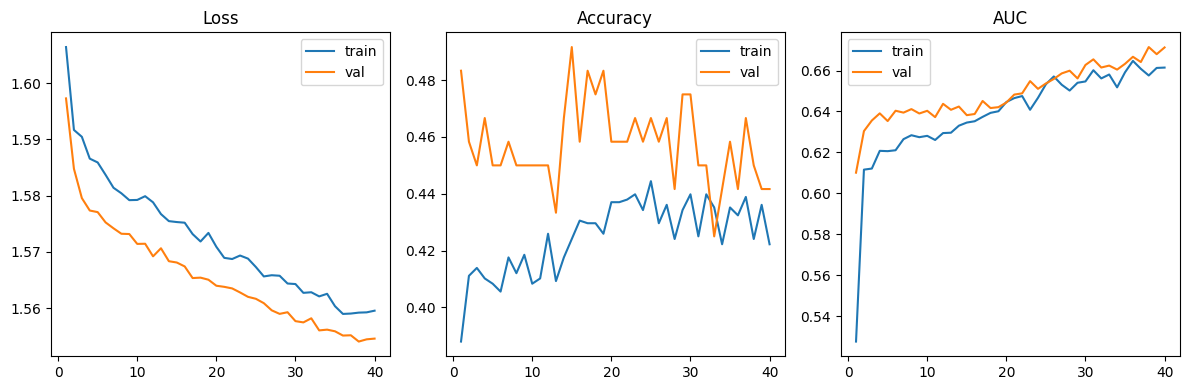

Final test metrics: (1.5691248607635497, 0.445, 0.6389058356402323)


In [146]:
# Reset data handler
dh = DataHandler(download=True, as_rgb=True)
dh.to_grayscale()
dh.normalize('minmax')

print("Starting Optimized Quantum Training...")

# Rulăm antrenarea
model, history, test_metrics = run_training(
    dh=dh,
    num_epochs=40,       # Mai multe epoci pentru că modelul complex învață mai fin
    batch_size=32,       # BATCH MIC (32) este secretul pentru generalizare în QML
    lr=1e-4,             # Rată mică (0.0001) pentru stabilitate
    resize=(28,28),      # Rezoluția originală e cea mai bună (nu 64x64!)
    grayscale=True,
    train_pct=1.0
    
)

print("Final test metrics:", test_metrics)

## NORMAL CNN TO COMPARE



In [141]:

# --- 1. Definim Modelul Clasic de Referință ---
class ClassicalCNN(nn.Module):
    def __init__(self, in_ch, n_classes):
        super().__init__()
        
        # Păstrăm EXACT aceeași arhitectură de extragere a trăsăturilor
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Aici e diferența: În loc de Quantum, avem un simplu strat liniar
            # Input 32 -> Output 5 (clase)
            nn.Linear(32, n_classes) 
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [143]:
def run_classical_training(dh, num_epochs=40, batch_size=32, lr=1e-4, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training CLASSICAL model on {device}...")
    
    # Dataloaders
    loaders = build_dataloaders_fast(dh, batch_size=batch_size, device=device)
    num_classes = len(np.unique(dh.labels["train"]))
    in_ch = dh.images["train"].shape[-1]
    
    # Instanțiem modelul CLASIC
    model = ClassicalCNN(in_ch, num_classes).to(device)
    
    # Optimizator și Scheduler (Identic cu Quantum)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    
    # Ponderi (Identic cu Quantum - CRITIC pentru comparație)
    all_labels = dh.labels['train'].flatten()
    class_counts = np.bincount(all_labels)
    class_counts = np.where(class_counts == 0, 1, class_counts)
    weights = len(all_labels) / (len(class_counts) * class_counts)
    class_weights = torch.tensor(weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    history = {"val_auc": [], "val_loss": [], "train_loss": []}
    
    for epoch in range(1, num_epochs+1):
        tr_loss, tr_acc, tr_auc = train_epoch(model, loaders["train"], optimizer, device, criterion)
        val_loss, val_acc, val_auc = evaluate(model, loaders["val"], device, criterion)
        scheduler.step(val_loss)
        
        print(f"Classic Epoch {epoch:02d} | Val AUC: {val_auc:.4f} | Val Loss: {val_loss:.4f}")
        
        history["val_auc"].append(val_auc)
        history["val_loss"].append(val_loss)
        history["train_loss"].append(tr_loss)
        
    return model, history

Training CLASSICAL model on cpu...
Classic Epoch 01 | Val AUC: 0.6394 | Val Loss: 1.6279
Classic Epoch 01 | Val AUC: 0.6394 | Val Loss: 1.6279
Classic Epoch 02 | Val AUC: 0.6316 | Val Loss: 1.5888
Classic Epoch 02 | Val AUC: 0.6316 | Val Loss: 1.5888
Classic Epoch 03 | Val AUC: 0.6438 | Val Loss: 1.5586
Classic Epoch 03 | Val AUC: 0.6438 | Val Loss: 1.5586
Classic Epoch 04 | Val AUC: 0.6433 | Val Loss: 1.5455
Classic Epoch 04 | Val AUC: 0.6433 | Val Loss: 1.5455
Classic Epoch 05 | Val AUC: 0.6486 | Val Loss: 1.5373
Classic Epoch 05 | Val AUC: 0.6486 | Val Loss: 1.5373
Classic Epoch 06 | Val AUC: 0.6498 | Val Loss: 1.5358
Classic Epoch 06 | Val AUC: 0.6498 | Val Loss: 1.5358
Classic Epoch 07 | Val AUC: 0.6392 | Val Loss: 1.5331
Classic Epoch 07 | Val AUC: 0.6392 | Val Loss: 1.5331
Classic Epoch 08 | Val AUC: 0.6396 | Val Loss: 1.5345
Classic Epoch 08 | Val AUC: 0.6396 | Val Loss: 1.5345
Classic Epoch 09 | Val AUC: 0.6419 | Val Loss: 1.5280
Classic Epoch 09 | Val AUC: 0.6419 | Val Loss: 

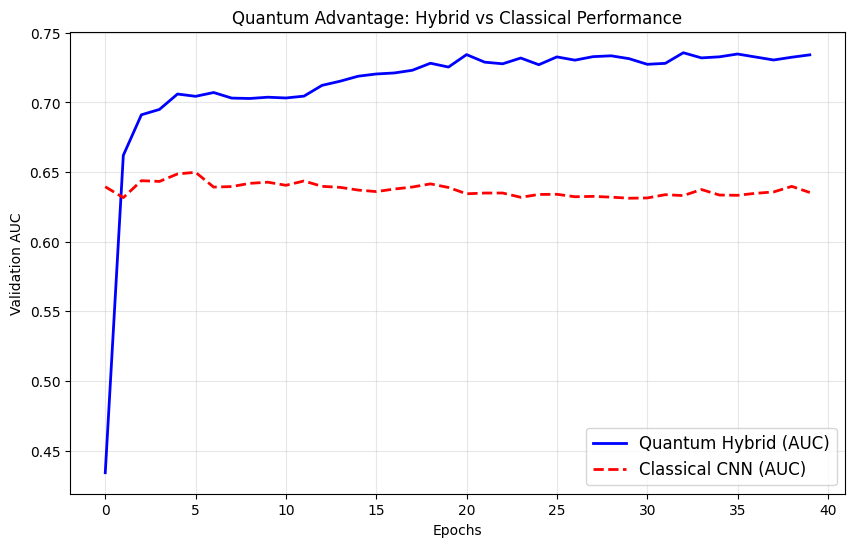

In [144]:
# A. Rulează antrenarea Clasică
dh = DataHandler(download=True, as_rgb=True)
dh.to_grayscale()
dh.normalize('minmax')

classic_model, classic_history = run_classical_training(
    dh, 
    num_epochs=40,   # Același număr ca la Quantum
    batch_size=32,   # Același batch
    lr=1e-4          # Același LR
)

# B. Încărcăm istoricul Cuantic (dacă nu e deja în variabila 'history')
import json
# Dacă l-ai salvat anterior:
# with open("final_quantum_history.json", "r") as f:
#     quantum_history = json.load(f)
# Altfel, folosim variabila 'history' din rularea anterioară:
quantum_history = history 

# C. PLOT FINAL: CLASIC vs QUANTUM
plt.figure(figsize=(10, 6))

# Curba Quantum
plt.plot(quantum_history['val_auc'], label='Quantum Hybrid (AUC)', color='blue', linewidth=2)
# Curba Clasică
plt.plot(classic_history['val_auc'], label='Classical CNN (AUC)', color='red', linestyle='--', linewidth=2)

plt.title("Quantum Advantage: Hybrid vs Classical Performance")
plt.xlabel("Epochs")
plt.ylabel("Validation AUC")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## Showing the advantages of quantum in small datasets

--- Începem Experimentul de Eficiență a Datelor ---
Procente de testat: [0.1, 0.3, 0.5, 0.8, 1.0]


   RULARE PENTRU 10.0% DIN DATE

[1/2] Antrenare Quantum HCNN (10.0%)...
Started training on  cpu ...
Calculating class weights...
Model built. Starting loop...
Epoch 01 | Train loss 1.6284 acc 0.4537 auc 0.3862
          | Val   loss 1.6257 acc 0.4500 auc 0.4070
Epoch 01 | Train loss 1.6284 acc 0.4537 auc 0.3862
          | Val   loss 1.6257 acc 0.4500 auc 0.4070
Epoch 02 | Train loss 1.6280 acc 0.4537 auc 0.3874
          | Val   loss 1.6259 acc 0.4500 auc 0.4236
Epoch 02 | Train loss 1.6280 acc 0.4537 auc 0.3874
          | Val   loss 1.6259 acc 0.4500 auc 0.4236
Epoch 03 | Train loss 1.6240 acc 0.4537 auc 0.4142
          | Val   loss 1.6263 acc 0.4500 auc 0.4727
Epoch 03 | Train loss 1.6240 acc 0.4537 auc 0.4142
          | Val   loss 1.6263 acc 0.4500 auc 0.4727
Epoch 04 | Train loss 1.6212 acc 0.4537 auc 0.4452
          | Val   loss 1.6267 acc 0.4500 auc 0.4925
Epoch 04 | Train l

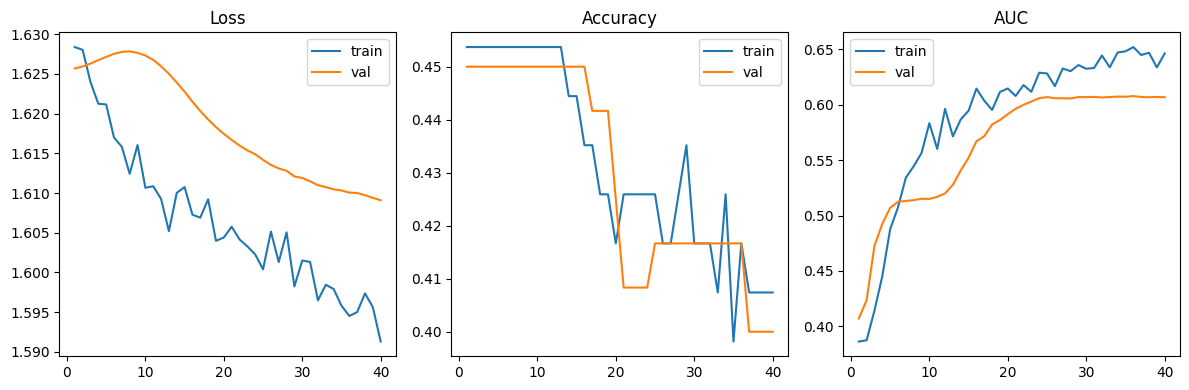

-> Quantum Test AUC: 0.5650

[2/2] Antrenare Classical CNN (10.0%)...
Training CLASSICAL model on cpu...
Classic Epoch 01 | Val AUC: 0.6608 | Val Loss: 1.6118
Classic Epoch 01 | Val AUC: 0.6608 | Val Loss: 1.6118
Classic Epoch 02 | Val AUC: 0.6765 | Val Loss: 1.6164
Classic Epoch 02 | Val AUC: 0.6765 | Val Loss: 1.6164
Classic Epoch 03 | Val AUC: 0.6755 | Val Loss: 1.6230
Classic Epoch 03 | Val AUC: 0.6755 | Val Loss: 1.6230
Classic Epoch 04 | Val AUC: 0.6772 | Val Loss: 1.6297
Classic Epoch 04 | Val AUC: 0.6772 | Val Loss: 1.6297
Classic Epoch 05 | Val AUC: 0.6782 | Val Loss: 1.6345
Classic Epoch 05 | Val AUC: 0.6782 | Val Loss: 1.6345
Classic Epoch 06 | Val AUC: 0.6800 | Val Loss: 1.6367
Classic Epoch 06 | Val AUC: 0.6800 | Val Loss: 1.6367
Classic Epoch 07 | Val AUC: 0.6834 | Val Loss: 1.6356
Classic Epoch 07 | Val AUC: 0.6834 | Val Loss: 1.6356
Classic Epoch 08 | Val AUC: 0.6827 | Val Loss: 1.6310
Classic Epoch 08 | Val AUC: 0.6827 | Val Loss: 1.6310
Classic Epoch 09 | Val AUC: 0.6

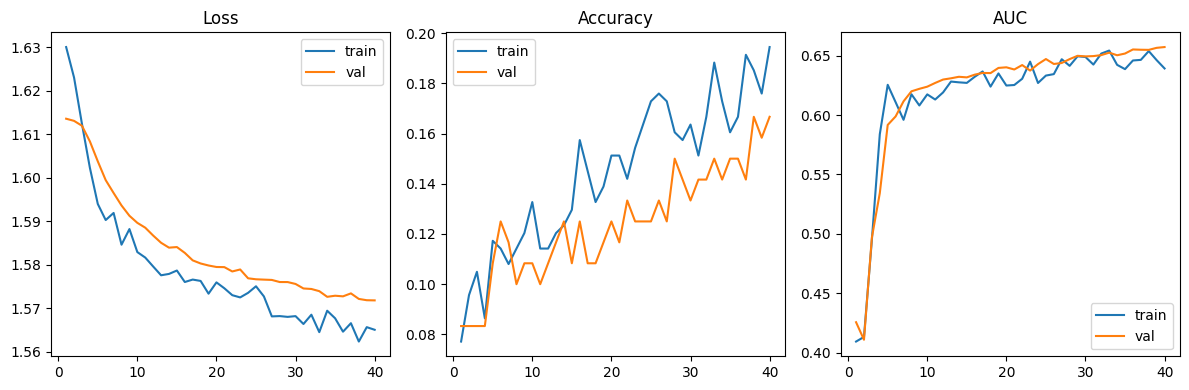

-> Quantum Test AUC: 0.5694

[2/2] Antrenare Classical CNN (30.0%)...
Training CLASSICAL model on cpu...
Classic Epoch 01 | Val AUC: 0.5622 | Val Loss: 1.6211
Classic Epoch 01 | Val AUC: 0.5622 | Val Loss: 1.6211
Classic Epoch 02 | Val AUC: 0.5670 | Val Loss: 1.6213
Classic Epoch 02 | Val AUC: 0.5670 | Val Loss: 1.6213
Classic Epoch 03 | Val AUC: 0.5966 | Val Loss: 1.6100
Classic Epoch 03 | Val AUC: 0.5966 | Val Loss: 1.6100
Classic Epoch 04 | Val AUC: 0.5977 | Val Loss: 1.5917
Classic Epoch 04 | Val AUC: 0.5977 | Val Loss: 1.5917
Classic Epoch 05 | Val AUC: 0.5649 | Val Loss: 1.5860
Classic Epoch 05 | Val AUC: 0.5649 | Val Loss: 1.5860
Classic Epoch 06 | Val AUC: 0.5729 | Val Loss: 1.5802
Classic Epoch 06 | Val AUC: 0.5729 | Val Loss: 1.5802
Classic Epoch 07 | Val AUC: 0.5767 | Val Loss: 1.5798
Classic Epoch 07 | Val AUC: 0.5767 | Val Loss: 1.5798
Classic Epoch 08 | Val AUC: 0.5721 | Val Loss: 1.5880
Classic Epoch 08 | Val AUC: 0.5721 | Val Loss: 1.5880
Classic Epoch 09 | Val AUC: 0.5

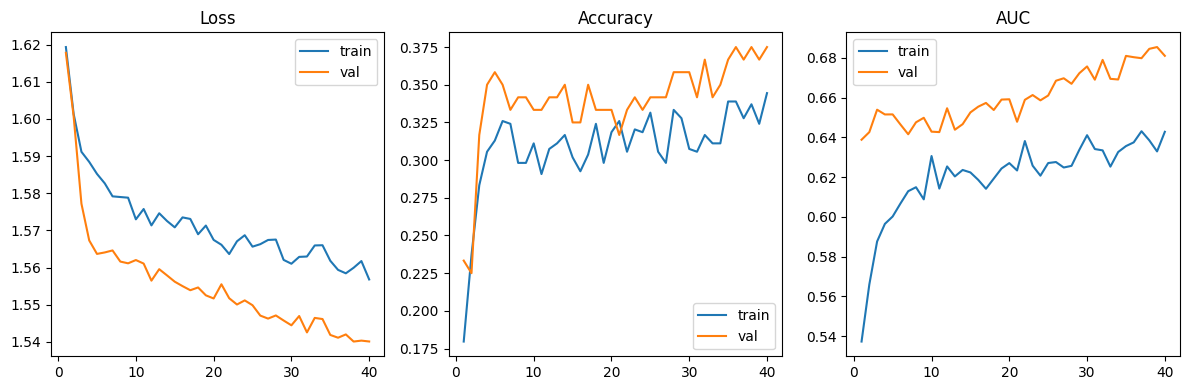

-> Quantum Test AUC: 0.5550

[2/2] Antrenare Classical CNN (50.0%)...
Training CLASSICAL model on cpu...
Training CLASSICAL model on cpu...
Classic Epoch 01 | Val AUC: 0.6007 | Val Loss: 1.6328
Classic Epoch 01 | Val AUC: 0.6007 | Val Loss: 1.6328
Classic Epoch 02 | Val AUC: 0.5965 | Val Loss: 1.6410
Classic Epoch 02 | Val AUC: 0.5965 | Val Loss: 1.6410
Classic Epoch 03 | Val AUC: 0.6029 | Val Loss: 1.6068
Classic Epoch 03 | Val AUC: 0.6029 | Val Loss: 1.6068
Classic Epoch 04 | Val AUC: 0.6282 | Val Loss: 1.5761
Classic Epoch 04 | Val AUC: 0.6282 | Val Loss: 1.5761
Classic Epoch 05 | Val AUC: 0.6398 | Val Loss: 1.5611
Classic Epoch 05 | Val AUC: 0.6398 | Val Loss: 1.5611
Classic Epoch 06 | Val AUC: 0.6465 | Val Loss: 1.5521
Classic Epoch 06 | Val AUC: 0.6465 | Val Loss: 1.5521
Classic Epoch 07 | Val AUC: 0.6586 | Val Loss: 1.5458
Classic Epoch 07 | Val AUC: 0.6586 | Val Loss: 1.5458
Classic Epoch 08 | Val AUC: 0.6609 | Val Loss: 1.5410
Classic Epoch 08 | Val AUC: 0.6609 | Val Loss: 1.5

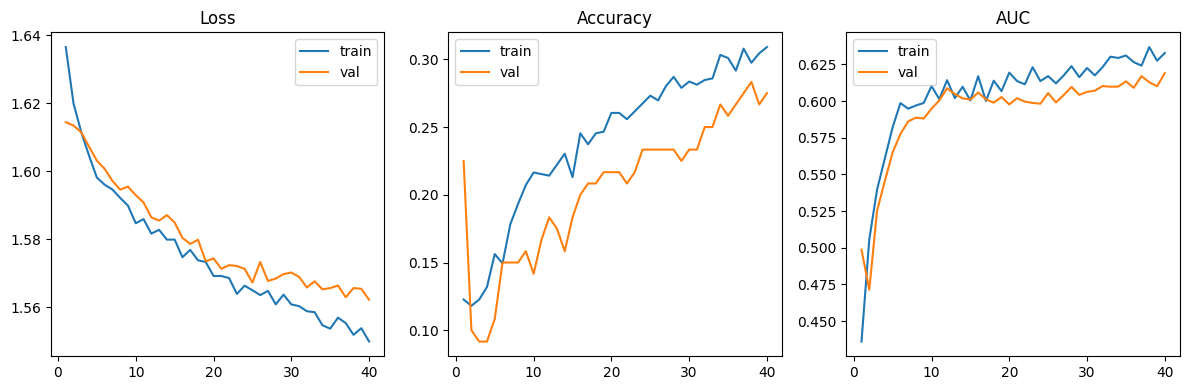

-> Quantum Test AUC: 0.5548

[2/2] Antrenare Classical CNN (80.0%)...
Training CLASSICAL model on cpu...
Training CLASSICAL model on cpu...
Classic Epoch 01 | Val AUC: 0.6381 | Val Loss: 1.6460
Classic Epoch 01 | Val AUC: 0.6381 | Val Loss: 1.6460
Classic Epoch 02 | Val AUC: 0.6656 | Val Loss: 1.5890
Classic Epoch 02 | Val AUC: 0.6656 | Val Loss: 1.5890
Classic Epoch 03 | Val AUC: 0.6589 | Val Loss: 1.5598
Classic Epoch 03 | Val AUC: 0.6589 | Val Loss: 1.5598
Classic Epoch 04 | Val AUC: 0.6592 | Val Loss: 1.5493
Classic Epoch 04 | Val AUC: 0.6592 | Val Loss: 1.5493
Classic Epoch 05 | Val AUC: 0.6670 | Val Loss: 1.5439
Classic Epoch 05 | Val AUC: 0.6670 | Val Loss: 1.5439
Classic Epoch 06 | Val AUC: 0.6806 | Val Loss: 1.5408
Classic Epoch 06 | Val AUC: 0.6806 | Val Loss: 1.5408
Classic Epoch 07 | Val AUC: 0.6799 | Val Loss: 1.5340
Classic Epoch 07 | Val AUC: 0.6799 | Val Loss: 1.5340
Classic Epoch 08 | Val AUC: 0.6817 | Val Loss: 1.5299
Classic Epoch 08 | Val AUC: 0.6817 | Val Loss: 1.5

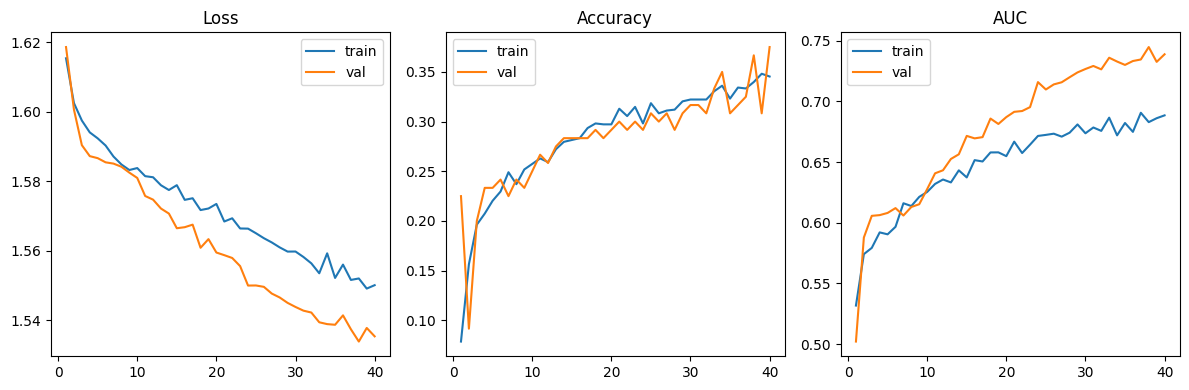

-> Quantum Test AUC: 0.6082

[2/2] Antrenare Classical CNN (100.0%)...
Training CLASSICAL model on cpu...
Training CLASSICAL model on cpu...
Classic Epoch 01 | Val AUC: 0.6481 | Val Loss: 1.5915
Classic Epoch 01 | Val AUC: 0.6481 | Val Loss: 1.5915
Classic Epoch 02 | Val AUC: 0.6482 | Val Loss: 1.5620
Classic Epoch 02 | Val AUC: 0.6482 | Val Loss: 1.5620
Classic Epoch 03 | Val AUC: 0.6476 | Val Loss: 1.5591
Classic Epoch 03 | Val AUC: 0.6476 | Val Loss: 1.5591
Classic Epoch 04 | Val AUC: 0.6578 | Val Loss: 1.5530
Classic Epoch 04 | Val AUC: 0.6578 | Val Loss: 1.5530
Classic Epoch 05 | Val AUC: 0.6721 | Val Loss: 1.5490
Classic Epoch 05 | Val AUC: 0.6721 | Val Loss: 1.5490
Classic Epoch 06 | Val AUC: 0.6689 | Val Loss: 1.5450
Classic Epoch 06 | Val AUC: 0.6689 | Val Loss: 1.5450
Classic Epoch 07 | Val AUC: 0.6812 | Val Loss: 1.5416
Classic Epoch 07 | Val AUC: 0.6812 | Val Loss: 1.5416
Classic Epoch 08 | Val AUC: 0.6836 | Val Loss: 1.5403
Classic Epoch 08 | Val AUC: 0.6836 | Val Loss: 1.

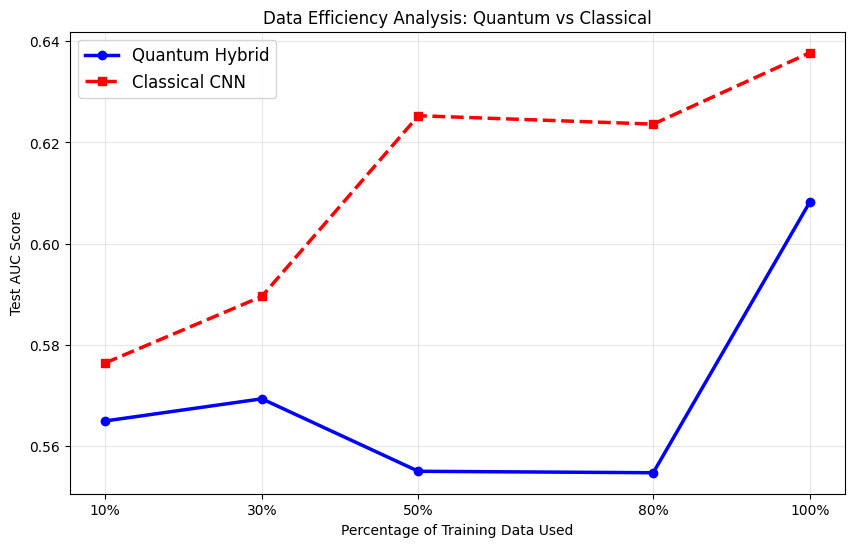

In [145]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. Lista de procente pe care vrei să testezi
percentages = [0.1, 0.3, 0.5, 0.8, 1.0]

# 2. Aici vom salva doar AUC-ul final de test pentru fiecare rulare
quantum_test_aucs = []
classical_test_aucs = []

print(f"--- Începem Experimentul de Eficiență a Datelor ---")
print(f"Procente de testat: {percentages}\n")

for pct in percentages:
    print(f"\n{'='*40}")
    print(f"   RULARE PENTRU {pct*100}% DIN DATE")
    print(f"{'='*40}")

    # -------------------------------------------------
    # A. MODELUL QUANTUM (HCNN)
    # -------------------------------------------------
    print(f"\n[1/2] Antrenare Quantum HCNN ({pct*100}%)...")
    
    # Resetăm datele
    dh_q = DataHandler(download=True, as_rgb=True)
    dh_q.to_grayscale()
    dh_q.normalize('minmax')
    
    # run_training are deja parametrul 'train_pct' implementat
    # Returnează: model, history, (test_loss, test_acc, test_auc)
    _, _, q_metrics = run_training(
        dh=dh_q,
        num_epochs=40,       
        batch_size=32,       
        lr=1e-4,             
        resize=(28,28),      
        grayscale=True,
        train_pct=pct,       # Aici limităm datele
        device="cuda" if torch.cuda.is_available() else "cpu"
    )
    
    # Salvăm doar AUC-ul de test (index 2 din tuplul metrics)
    q_final_auc = q_metrics[2]
    quantum_test_aucs.append(q_final_auc)
    print(f"-> Quantum Test AUC: {q_final_auc:.4f}")

    # -------------------------------------------------
    # B. MODELUL CLASIC (CNN)
    # -------------------------------------------------
    print(f"\n[2/2] Antrenare Classical CNN ({pct*100}%)...")
    
    # Resetăm datele din nou pentru clasic
    dh_c = DataHandler(download=True, as_rgb=True)
    dh_c.to_grayscale()
    dh_c.normalize('minmax')
    
    # Aplicăm manual reducerea datelor pentru clasic (dacă funcția nu o are)
    if pct < 1.0:
        dh_c.select_train_percentage(pct, seed=42)
    
    # Antrenăm
    classic_model, _ = run_classical_training(
        dh_c, 
        num_epochs=40,   
        batch_size=32,   
        lr=1e-4
    )
    
    # !IMPORTANT: Trebuie să evaluăm modelul clasic pe setul de TEST final
    # Reconstruim loader-ul de test (setul de test e mereu 100%, nu se reduce)
    test_loader_c = build_dataloaders_fast(dh_c, batch_size=32, device="cuda" if torch.cuda.is_available() else "cpu")["test"]
    
    # Evaluăm
    criterion = torch.nn.CrossEntropyLoss() # Folosim loss simplu la evaluare
    _, _, c_final_auc = evaluate(classic_model, test_loader_c, "cuda" if torch.cuda.is_available() else "cpu", criterion)
    
    classical_test_aucs.append(c_final_auc)
    print(f"-> Classical Test AUC: {c_final_auc:.4f}")

# -------------------------------------------------
# C. PLOT FINAL: DATA EFFICIENCY
# -------------------------------------------------
print("\n--- Rezultate Finale ---")
print("Data % | Quantum AUC | Classic AUC")
for i, p in enumerate(percentages):
    print(f"{p*100:3.0f}%  |   {quantum_test_aucs[i]:.4f}    |   {classical_test_aucs[i]:.4f}")

plt.figure(figsize=(10, 6))

# Linia Quantum
plt.plot(percentages, quantum_test_aucs, marker='o', label='Quantum Hybrid', color='blue', linewidth=2.5)
# Linia Clasică
plt.plot(percentages, classical_test_aucs, marker='s', label='Classical CNN', color='red', linestyle='--', linewidth=2.5)

plt.title("Data Efficiency Analysis: Quantum vs Classical")
plt.xlabel("Percentage of Training Data Used")
plt.ylabel("Test AUC Score")
plt.xticks(percentages, [f"{int(p*100)}%" for p in percentages])
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Salvăm graficul
plt.savefig("data_efficiency_comparison.png")
plt.show()

.






## Model saver 


In [138]:
checkpoint_path = "Saved_models/cnnmic1_weights_3layerreup.pth"
history_path = "Saved_models/cnnmic1_weights_3layerreup.json"
torch.save(model.state_dict(), checkpoint_path)
with open(history_path, "w", encoding="utf-8") as fp:
    json.dump(history, fp)
print(f"Saved weights to {checkpoint_path} and history to {history_path}.")
metrics_dict = {
    "test_loss": test_metrics[0],
    "test_acc": test_metrics[1],
    "test_auc": test_metrics[2]
}

# Save to a separate JSON file
with open("Saved_models/cnnmic1_weights_3layerreup_testset.json", "w") as f:
    json.dump(metrics_dict, f, indent=4)


Saved weights to Saved_models/cnnmic1_weights_3layerreup.pth and history to Saved_models/cnnmic1_weights_3layerreup.json.


In [ ]:
input = None
output = None